# Topic modeling on eu-timeline textual data

## Importing libraries

In [1]:
import sys
sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))

import os
os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

from gensim.models import LdaModel, LsiModel
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import filter_stop_words,\
    filter_pos, filter_stop_words_on_a_span_list, select_pos, spacy_stop_words

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

## Fetching data from document store

In [2]:
eu_timeline = Dataset.EU_ACTION_TIMELINE.fetch()

eu_timeline.fillna(value="", inplace=True)

document_corpus = eu_timeline['title'].map(str) + '. ' + \
                  eu_timeline['abstract'].map(str) + '. ' + \
                  eu_timeline['detail_title'].map(str) + '.' + \
                  eu_timeline['detail_content'].map(str)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100% (171 of 171) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


## Data preprocessing

- data cleanup
- turn corpus into spacy Docs

In [3]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]", "-", "_", "\r"]

document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls)
document_corpus = document_corpus.apply(clean_remove_emails)
document_corpus = document_corpus.apply(clean_remove_currency_symbols)
spacy_corpus = document_corpus.apply(nlp)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words
   - nouns
   - verbs
   - noun phrases

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



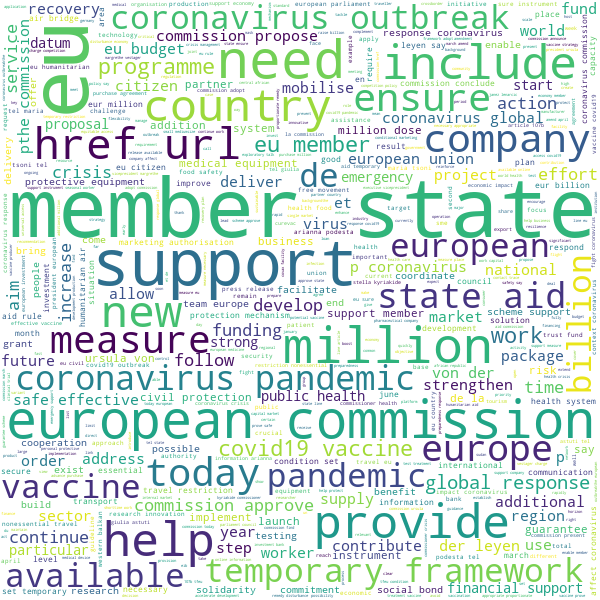

In [4]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in word_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



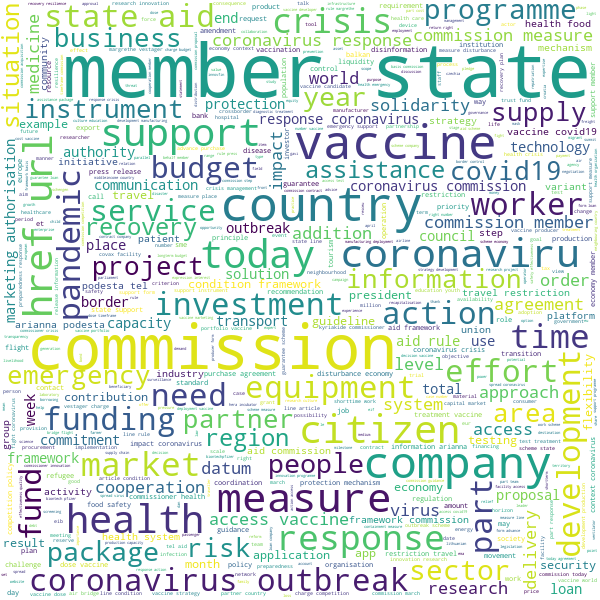

In [5]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



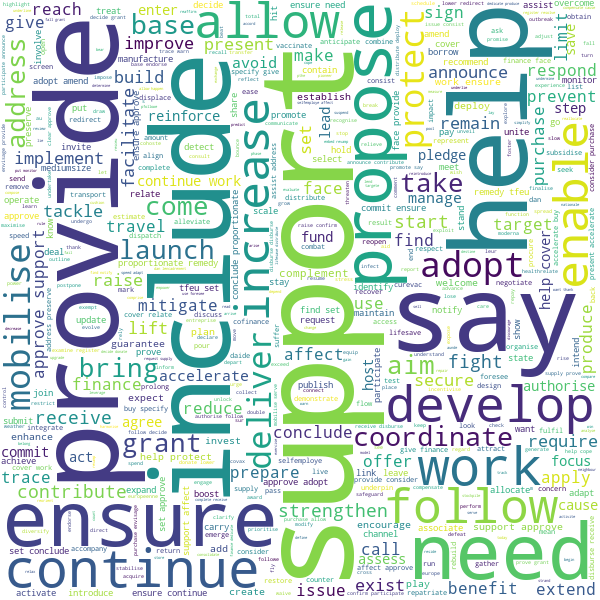

In [6]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(filter_stop_words)
verb_corpus = verb_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in verb_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



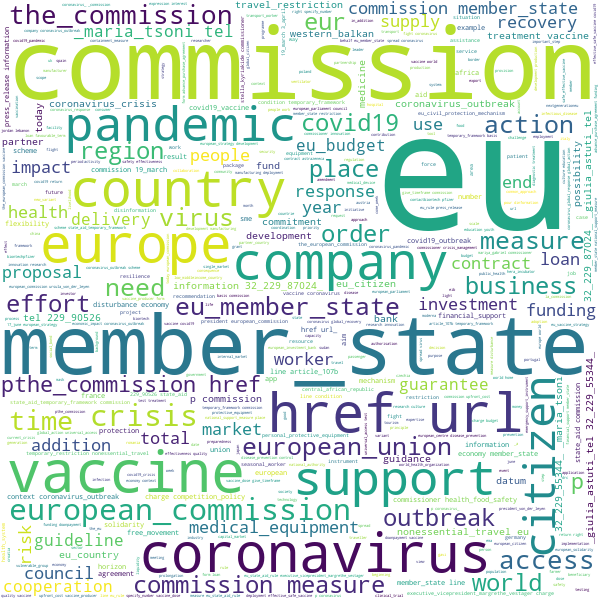

In [7]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )

## Train LDA + LSI models

- create a dictionary and a corpus with each corpora
- train LDA models
- train LSI models
- visualize the results (LDA)

In [8]:
word_dictionary = gensim.corpora.Dictionary(word_corpus)
noun_dictionary = gensim.corpora.Dictionary(noun_corpus)
verb_dictionary = gensim.corpora.Dictionary(verb_corpus)
noun_phrases_dictionary = gensim.corpora.Dictionary(noun_phrase_corpus)

word_gensim_corpus = [word_dictionary.doc2bow(docs) for docs in word_corpus]
noun_gensim_corpus = [noun_dictionary.doc2bow(docs) for docs in noun_corpus]
verb_gensim_corpus = [verb_dictionary.doc2bow(docs) for docs in verb_corpus]
noun_phrases_gensim_corpus = [noun_phrases_dictionary.doc2bow(docs) for docs in noun_phrase_corpus]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
word_lda_model = LdaModel(corpus=word_gensim_corpus, num_topics=5, id2word=word_dictionary, chunksize=30, random_state=40)
noun_lda_model = LdaModel(corpus=noun_gensim_corpus, num_topics=3, id2word=noun_dictionary, chunksize=30, random_state=40)
verb_lda_model = LdaModel(corpus=verb_gensim_corpus, num_topics=4, id2word=verb_dictionary, chunksize=20, random_state=40)
noun_phrases_lda_model = LdaModel(corpus=noun_phrases_gensim_corpus, num_topics=5, id2word=noun_phrases_dictionary, chunksize=30, random_state=40)

word_lsa_model = LsiModel(corpus=word_gensim_corpus, num_topics=6, id2word=word_dictionary, chunksize=300)
noun_lsa_model = LsiModel(corpus=noun_gensim_corpus, num_topics=6, id2word=noun_dictionary, chunksize=300)
verb_lsa_model = LsiModel(corpus=verb_gensim_corpus, num_topics=6, id2word=verb_dictionary, chunksize=300)
noun_phrases_lsa_model = LsiModel(corpus=noun_phrases_gensim_corpus, num_topics=6, id2word=noun_phrases_dictionary, chunksize=300)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
pyLDAvis.enable_notebook()
word_visualization = pyLDAvis.gensim_models.prepare(word_lda_model, word_gensim_corpus, word_dictionary)
word_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076862 -0.080611       1        1  29.581218
3     -0.015480  0.126578       2        1  22.621648
4      0.174812 -0.019198       3        1  20.298759
0     -0.097976  0.004100       4        1  18.050307
1      0.015505 -0.030869       5        1   9.448068, topic_info=              Term        Freq       Total Category  logprob  loglift
352        vaccine  744.000000  744.000000  Default  30.0000  30.0000
1983            de  396.000000  396.000000  Default  29.0000  29.0000
1295  humanitarian  206.000000  206.000000  Default  28.0000  28.0000
64         billion  418.000000  418.000000  Default  27.0000  27.0000
2048            la  246.000000  246.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
12        european   50.388766  891.752907   Topic5  -5.1017  -0.5141
172           help   40.354416  345.747549   Topic5  -5.3238   0.2114
268        provide   38.455911  328.138806   Topic5  -5.3720   0.2154
326         supply   34.622264  180.491094   Topic5  -5.4770   0.7082
520        measure   34.995001  420.402227   Topic5  -5.4663  -0.1266

[369 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1903      1  0.004288     +32
1903      2  0.034305     +32
1903      3  0.947681     +32
1903      5  0.012864     +32
29        1  0.217753    2020
...     ...       ...     ...
660       3  0.012030  worker
660       4  0.162408  worker
660       5  0.042106  worker
4772      4  0.099608   yemen
4772      5  0.796867   yemen

[940 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [11]:
noun_visualization = pyLDAvis.gensim_models.prepare(noun_lda_model, noun_gensim_corpus, noun_dictionary)
noun_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.018791 -0.085718       1        1  36.386845
0     -0.116761  0.031607       2        1  35.421247
1      0.097970  0.054111       3        1  28.191907, topic_info=          Term        Freq       Total Category  logprob  loglift
170    vaccine  837.000000  837.000000  Default  30.0000  30.0000
40     company  306.000000  306.000000  Default  29.0000  29.0000
1010      bond  171.000000  171.000000  Default  28.0000  28.0000
53        dose  125.000000  125.000000  Default  27.0000  27.0000
134   research  217.000000  217.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
162      today   72.638406  234.114886   Topic3  -5.0817   0.0958
3      country   76.631629  403.180296   Topic3  -5.0282  -0.3942
78      health   68.666707  461.146982   Topic3  -5.1380  -0.6383
10     support   66.504715  400.174495   Topic3  -5.1700  -0.5285
91        loan   58.273799  152.649983   Topic3  -5.3021   0.3031

[235 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
15        1  0.273911  access
15        2  0.176418  access
15        3  0.552465  access
17        1  0.326286  action
17        2  0.487132  action
...     ...       ...     ...
318       2  0.212257    work
318       3  0.067922    work
319       1  0.295349  worker
319       2  0.584670  worker
319       3  0.120551  worker

[451 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

t-SNE for noun_lda_model

In [12]:
# Get the topics weights (nr. of docs. x nr. of topics)
weights = np.zeros((len(eu_timeline), 3))

for doc_nr, topics_info in enumerate(noun_lda_model[noun_gensim_corpus]):
    for topic_info in topics_info:
        topic_idx = topic_info[0]
        topic_weight = topic_info[1]
        weights[doc_nr][topic_idx] = topic_weight

# Dominant topic number in each doc
dominant_topics = np.argmax(weights, axis=1)

# t-SNE Dimension Reduction
t_sne_model = TSNE(n_components=2, verbose=1, random_state=42)
t_sne_lda = t_sne_model.fit_transform(weights)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
colors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

source = ColumnDataSource(dict(
    x=t_sne_lda[:,0],
    y=t_sne_lda[:,1],
    color=colors[dominant_topics],
    label=pd.Series(dominant_topics).apply(lambda x: "Topic " + str(x + 1))
))

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=900, plot_height=700)

plot.scatter(x="x", y="y", color="color", legend_group="label", source=source)

# Display legend in the top left corner
plot.legend.location = "top_left"

# Add a title to your legend
plot.legend.title = "Topics"

show(plot)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify a

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 171 samples in 0.000s...
[t-SNE] Computed neighbors for 171 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 171 / 171
[t-SNE] Mean sigma: 0.064591
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.913742


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[t-SNE] KL divergence after 1000 iterations: 0.148751


Loading BokehJS ...

In [13]:
verb_visualization = pyLDAvis.gensim_models.prepare(verb_lda_model, verb_gensim_corpus, verb_dictionary)
verb_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.062636  0.058639       1        1  37.214699
0      0.103945 -0.016851       2        1  23.964350
3     -0.054550 -0.114872       3        1  21.878561
1     -0.112031  0.073084       4        1  16.942390, topic_info=           Term        Freq       Total Category  logprob  loglift
64      receive  122.000000  122.000000  Default  30.0000  30.0000
100     develop  131.000000  131.000000  Default  29.0000  29.0000
5    accelerate   72.000000   72.000000  Default  28.0000  28.0000
431    disburse   62.000000   62.000000  Default  27.0000  27.0000
59      propose  184.000000  184.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
4       support   32.117457  523.454792   Topic4  -4.3654  -1.0157
161       allow   22.023268  111.154337   Topic4  -4.7427   0.1565
82         work   23.925941  208.490127   Topic4  -4.6599  -0.3896
61      provide   23.835771  318.001521   Topic4  -4.6637  -0.8155
60      protect   19.879422  163.297238   Topic4  -4.8452  -0.3305

[269 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
758       2  0.927869  "background
5         1  0.055314   accelerate
5         2  0.082970   accelerate
5         3  0.857361   accelerate
5         4  0.013828   accelerate
...     ...       ...          ...
191       2  0.773202         wish
82        1  0.494028         work
82        2  0.239820         work
82        3  0.153484         work
82        4  0.115113         work

[541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [14]:
noun_phrases_visualization = pyLDAvis.gensim_models.prepare(noun_phrases_lda_model, noun_phrases_gensim_corpus, noun_phrases_dictionary)
noun_phrases_visualization


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.142239 -0.061255       1        1  30.362393
1     -0.097951 -0.119593       2        1  22.740676
0      0.058106  0.057460       3        1  19.240808
4     -0.045062  0.059819       4        1  17.675845
2     -0.057332  0.063569       5        1   9.980278, topic_info=              Term        Freq       Total Category  logprob  loglift
212        vaccine  276.000000  276.000000  Default  30.0000  30.0000
147   member_state  541.000000  541.000000  Default  29.0000  29.0000
666    information  119.000000  119.000000  Default  28.0000  28.0000
1697           +32   71.000000   71.000000  Default  27.0000  27.0000
206      treatment   88.000000   88.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
47         country    7.554808  118.317813   Topic5  -6.1651  -0.4466
257         crisis    6.861559   84.569564   Topic5  -6.2614  -0.2071
81          europe    7.238507  151.727023   Topic5  -6.2079  -0.7381
12         support    6.896243  106.292435   Topic5  -6.2563  -0.4307
45     coronavirus    6.733741  216.186543   Topic5  -6.2802  -1.1645

[353 rows x 6 columns], token_table=      Topic      Freq                         Term
term                                              
1697      1  0.042239                          +32
1697      3  0.943344                          +32
1697      4  0.014080                          +32
1697      5  0.014080                          +32
2594      1  0.233897  +32_229_55344_;_maria_tsoni
...     ...       ...                          ...
219       2  0.699171                        world
219       3  0.036798                        world
219       4  0.159460                        world
219       5  0.036798                        world
823       4  0.939568    world_health_organisation

[675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])